<a href="https://colab.research.google.com/github/cjakuc/DS-Unit-2-Kaggle-Challenge/blob/master/Tanz_Kaggle_Comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 194kB 3.0MB/s 
     |████████████████████████████████| 614kB 41.5MB/s 
     |████████████████████████████████| 1.5MB 43.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 235kB 53.7MB/s 
     |████████████████████████████████| 307kB 54.2MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 215kB 39.1MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 747kB 57.2MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.5.0-py2.py3-none-any.whl size=241329 sha256=4905951cf85a70a47ae1a2027b1b9d139aa7b4e5b83913f9554b7f7ec22145c5
  Stored in directory: /root/.cache/pip/wheels/9b/c9/f1/4a2f30c760e017f3e2f46be999c4597a93d126ef5ea38e276f
  Created wheel for confuse: filename=confuse-1.0.0-cp36

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

## Do train/validate/test split with the Tanzania Waterpumps data.

In [0]:
# Split train into train and val
from sklearn.model_selection import train_test_split

train, val = train_test_split(train,
                              train_size=0.80,
                              test_size=0.20,
                              stratify=train['status_group'],
                              random_state=42)

## Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
import numpy as np

def wrangle(X):
  """Wrangle, train, validate, and test sets in the same way"""

  X = X.copy()

  # Fix the latitude & longitudes
  X['latitude'] = X['latitude'].replace(-2e-08,0)
  cols_with_zeros = ['longitude','latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
  
  # Drop duplicate quantity column
  # Drop num_private because of too many zeros
  X = X.drop(columns=['quantity_group','num_private'])
  
  # Change date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])

  # Reduce cardinality:
  # by replacing the non-top founders, installers w/ "other"
  top15 = X['funder'].value_counts()[:15].index
  X.loc[~X['funder'].isin(top15), 'funder'] = 'other'

  top10 = X['installer'].value_counts()[:10].index
  X.loc[~X['installer'].isin(top10), 'installer'] = 'other'

  top30 = X['lga'].value_counts()[:30].index
  X.loc[~X['lga'].isin(top30), 'lga'] = 'other'

  # Return the wrangled dataframe
  return X

# Wrangle train, val, and test
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## Make a function that selects features, pipes, encodes, imputes, fits a decision tree, and returns pipeline and train/val scores

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
# Define a function that selects features, pipes, encodes, imputes, and 
# fits a decision tree
# Returns the pipeline and features

def full_pipe(train,val,test):

  # Features:
  # Select features
  target = 'status_group'
  # Drop target & id from train columns
  train_features = train.drop(columns=[target, 'id'])
  # Get a list of numeric features
  numeric_features = train_features.select_dtypes(include='number').columns.tolist()
  # Get a series w/ the cardinality of nonnumeric features
  cardinality = train_features.select_dtypes(exclude='number').nunique()
  # Get a list of features w/ cardinality <= 50
  categorical_features = cardinality[cardinality <= 50].index.tolist()
  # Combine the lists
  features = numeric_features + categorical_features
  
  # Arrange data into X features matrix and y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]

  # Pipeline
  pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
  )
  pipeline.fit(X_train, y_train)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

  return pipeline, features

In [6]:
pipeline, features = full_pipe(train,val,test)

Train Accuracy 0.808270202020202
Validation Accuracy 0.7760942760942761


## Define function to plot feature importance

In [0]:
import matplotlib.pyplot as plt

def plot_features(pipeline,val,features):
  %matplotlib inline
  X_val = val[features]
  model = pipeline.named_steps['decisiontreeclassifier']
  encoder = pipeline.named_steps['onehotencoder']
  encoded_columns = encoder.transform(X_val).columns
  importances = pd.Series(model.feature_importances_, encoded_columns)
  plt.figure(figsize=(10,30))
  importances.sort_values().plot.barh();

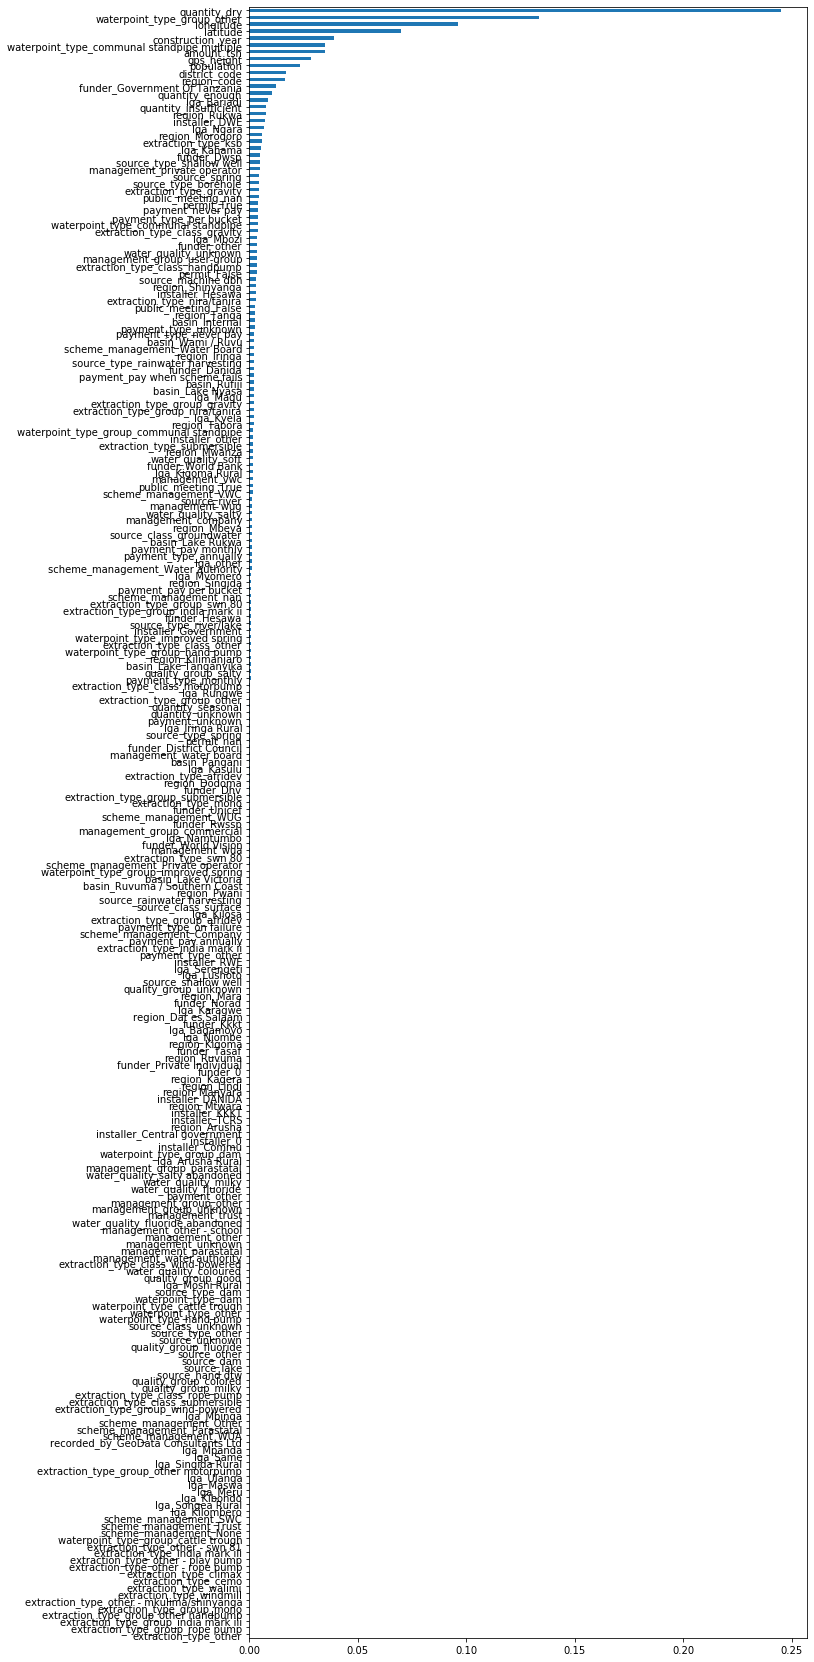

In [10]:
plot_features(pipeline,val,features)

## Make submission csv

In [0]:
X_test = test[features]
y_pred = pipeline.predict(X_test)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('https://github.com/cjakuc/DS-Unit-2-Kaggle-Challenge/raw/master/module1-decision-trees/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('cjakuc_tanzania_submission.csv', index=False)